<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Подготовим-данные-для-Bert" data-toc-modified-id="Подготовим-данные-для-Bert-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Подготовим данные для Bert</a></span></li><li><span><a href="#Подготовим-данные-с-помощью-DistilBERT-base-uncased-finetuned-SST-2" data-toc-modified-id="Подготовим-данные-с-помощью-DistilBERT-base-uncased-finetuned-SST-2-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовим данные с помощью DistilBERT base uncased finetuned SST-2</a></span></li><li><span><a href="#Подготовим-данные-для-векторизации-TF-IDF" data-toc-modified-id="Подготовим-данные-для-векторизации-TF-IDF-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовим данные для векторизации TF-IDF</a></span></li><li><span><a href="#Подготовим-данные-catboost" data-toc-modified-id="Подготовим-данные-catboost-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Подготовим данные catboost</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Bert" data-toc-modified-id="Bert-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Bert</a></span></li><li><span><a href="#DistilBERT-base-uncased-finetuned-SST-2" data-toc-modified-id="DistilBERT-base-uncased-finetuned-SST-2-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>DistilBERT base uncased finetuned SST-2</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>TF-IDF</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Проект для «Викишоп» с Bert

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Нужно обучить модель классифицировать комментарии на позитивные и негативные. У нас есть набор данных с разметкой о токсичности правок.

Требуется построить модель со значением метрики качества F1 не менее 0,75.

## Подготовка данных

In [1]:
# Для начала подключим все необходимые библиотеки
# импортируем библиотеку пандас
import pandas as pd 
# импортируем библиотеку numpy
import numpy as np
# импортируем библиотеку для расчета метрик
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, recall_score, precision_score
# импортируем библиотеку для разбития данных на выборки, кроссвалидации
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# импортируем библиотеку для логистической регрессии
from sklearn.linear_model import LogisticRegression 
# импортируем библиотеку для масштабирования
from sklearn.preprocessing import StandardScaler 
# импортируем библиотеку утилит
from sklearn.utils import shuffle 
# импортируем библиотеку для работы с графиками
import matplotlib.pyplot as plt 
#Библиотека для показания индикатора прогресса
from tqdm import notebook 
#TF-IDF, «счётчик слов для создания векторов»
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
# стоп слова
import nltk
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
#Импортируем библиотеку сеаборн для построения множественных графиков.
import seaborn as sns
# Библиотека для лемматизации
from pymystem3 import Mystem
# Библиотека регулярных выражений
import re 
# катбуст
from catboost import Pool, CatBoostClassifier
import IPython.display 
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\i.vereschagin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\i.vereschagin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\i.vereschagin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


0    0.898321
1    0.101679
Name: toxic, dtype: float64

<AxesSubplot:>

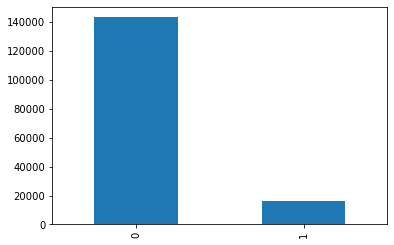

In [2]:
# откроем данные и выведем общую информацию 
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
print(df.info())
display(df.head())
display(df['toxic'].value_counts() / len(df['toxic']))
df['toxic'].value_counts().plot(kind='bar')

Мы имеем данные комментариев на английском языке и целевой признак toxic, означающий токсичный ли комментарий.Изменим кодировку в тексте.

В наших данных явный дисбаланс классов, метрика accuracy не подходит, так как при заполнении всех комментариев 0 у нас будет хорошое качество модели по этой метрика, но это не так. Будем использовать F1 метрику.

Построим модель без борьбы с дисбалансом, если метрика будет низкая, то уже будем бороться с дисбалансом.

In [3]:
df['text'] = df['text'].values.astype('U') 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


### Подготовим данные для Bert

In [4]:
features_bert = np.load('features_bert.npy')

In [5]:
features_train_bert, features_test_bert, target_train_bert, target_test_bert = train_test_split(
    features_bert, df['toxic'], test_size=0.25, random_state=12345) 

print(f"Размер тренировочной таблицы: {features_train_bert.shape}")
print(f"Размер тестовой таблицы: {features_test_bert.shape}")

Размер тренировочной таблицы: (119678, 768)
Размер тестовой таблицы: (39893, 768)


### Подготовим данные с помощью DistilBERT base uncased finetuned SST-2

Это fine-tune distilbert для определения насколько негативный/позитивный текст, модель выдает 2 параметра: negative и positive.

In [6]:
features_bert_unc = np.load('features_bert_uncased.npy')

In [7]:
features_train_bert_unc, features_test_bert_unc, target_train_bert_unc, target_test_bert_unc = train_test_split(
    features_bert_unc, df['toxic'], test_size=0.25, random_state=12345) 

print(f"Размер тренировочной таблицы: {features_train_bert_unc.shape}")
print(f"Размер тестовой таблицы: {features_test_bert_unc.shape}")

Размер тренировочной таблицы: (119678, 2)
Размер тестовой таблицы: (39893, 2)


### Подготовим данные для векторизации TF-IDF

1. Отчистка
2. Токенизация
3. Лемматизация

In [8]:
data = df.copy()

In [9]:
m = Mystem()
def checkExecTimeMystemOneText(texts):
    lol = lambda lst, sz: [lst[i:i+sz] for i in range(0, len(lst), sz)]
    txtpart = lol(texts, 10000)
    res = []
    for txtp in txtpart:
        alltexts = ' '.join([txt + ' brnew ' for txt in txtp])
        raw_txt = re.sub(r'[^a-zA-Z ]', ' ', alltexts)
        words = m.lemmatize(" ".join(raw_txt.split()))
        doc = []
        for txt in words:
            if txt.strip() != '':
                if txt == 'brnew':
                    res.append(" ".join(doc))
                    doc = []
                else:
                    doc.append(txt)
    return res

In [10]:
%%time
lemm_text = checkExecTimeMystemOneText(data['text'])

Wall time: 3min


In [11]:
data['lemm_text'] = lemm_text
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       159571 non-null  object
 1   toxic      159571 non-null  int64 
 2   lemm_text  159571 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


**Векторизация TF-IDF**

Дополнительно избавимся от стоп-слов

In [12]:
# Выдлим стоп-слова
stopwords = set(stopwords.words('english'))

In [13]:
# Разобьем данные на тестовую и тренировочную выборки 
corpus_train, corpus_test, target_train, target_test = train_test_split(
    data['lemm_text'], data['toxic'], test_size=0.25, random_state=12345)
print(f"Размер тренировочных данных: {len(corpus_train)}")
print(f"Размер тестовых данных: {len(corpus_test)}")

Размер тренировочных данных: 119678
Размер тестовых данных: 39893


In [14]:
# Проведем векторизацию
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(corpus_train)
features_test = count_tf_idf.transform(corpus_test)

In [15]:
print(f"Размер тренировочной таблицы: {features_train.shape}")
print(f"Размер тестовой таблицы: {features_test.shape}")

Размер тренировочной таблицы: (119678, 143178)
Размер тестовой таблицы: (39893, 143178)


### Подготовим данные catboost

In [16]:
# Разделим данные на обучающую, валидационнуб выборку и тестовую 3:1:1
train_cb, prom_cb = train_test_split(data, test_size=0.4, random_state=12345)
valid_cb, test_cb = train_test_split(prom_cb, test_size=0.5, random_state=12345)

In [17]:
train_pool = Pool(data=train_cb['lemm_text'].values, label=train_cb['toxic'].values, text_features=[0])
valid_pool = Pool(data=valid_cb['lemm_text'].values, label=valid_cb['toxic'].values, text_features=[0])
test_pool = Pool(data=test_cb['lemm_text'].values, label=test_cb['toxic'].values, text_features=[0])

### Вывод

**Вывод**

В нашем распоряжении комментарии пользователей с разметкой о токсичности. Комментарии на английском языке, имеется значительный дисбаланс классов, но пока не будем его поправлять, попробуем так обучить модель. 

Данные раздлили на выборки данные Bert я подготавливал в гугл колаб на GPU. Их преобразование занимает 1,5 часа.

Далее создадим модели предсказаний, обучим их и протестируем

## Обучение

In [18]:
# будем использовать только логистическую регрессию с балансировкой классов и без
# Создадим функцию
def logreg(features_train, features_test, target_train, target_test):
    lr = LogisticRegression(random_state=12345, solver='liblinear')
    lr.fit(features_train, target_train)  # обучим модель
    pred_test = lr.predict(features_test)  # предсказывания
    acc = lr.score(features_test, target_test)
    f1=f1_score(
        target_test, pred_test, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
    print('Точность без баланса: ',acc)  # правильность модели
    print('F1 без баланса: ',f1)
    
    lr_b = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')
    lr_b.fit(features_train, target_train)  # обучим модель
    pred_test_b = lr_b.predict(features_test)  # предсказывания
    acc_b = lr_b.score(features_test, target_test)
    f1_b=f1_score(
        target_test, pred_test_b, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
    print('Точность c балансом классов: ',acc_b)  # правильность модели
    print('F1 c балансом классов: ',f1_b)
    
    if f1 > f1_b:
        return lr, acc, f1
    return lr_b, acc_b, f1_b

### Bert

In [19]:
lr_bert, acc_bert, f1_bert = logreg(
    features_train_bert, features_test_bert, target_train_bert, target_test_bert)

Точность без баланса:  0.9530243401097936
F1 без баланса:  0.7439890710382513
Точность c балансом классов:  0.9092572631790038
F1 c балансом классов:  0.6697080291970803


### DistilBERT base uncased finetuned SST-2

In [20]:
lr_bert_unc, acc_bert_unc, f1_bert_unc = logreg(
    features_train_bert_unc, features_test_bert_unc, target_train_bert_unc, target_test_bert_unc)

Точность без баланса:  0.8975509487880079
F1 без баланса:  0.0
Точность c балансом классов:  0.4246108339808989
F1 c балансом классов:  0.2180814824908026


### TF-IDF

In [21]:
lr, acc, f1 = logreg(
    features_train, features_test, target_train, target_test)

Точность без баланса:  0.9554057102749856
F1 без баланса:  0.7367953839325344
Точность c балансом классов:  0.944401273406362
F1 c балансом классов:  0.7588081774684645


###  Catboost

In [22]:
# Создадим функцию модели
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
        #task_type='GPU',
        loss_function='Logloss',
        iterations=1000, #1000
        eval_metric='F1',
        od_type='Iter',
        early_stopping_rounds=200,
        **kwargs)
    return model.fit(
        train_pool,
        eval_set=test_pool,
        verbose= 200, #200
        plot=True,
        use_best_model=True
    )

In [23]:
model_cb = fit_model(
    train_pool, valid_pool,
    learning_rate=0.15, #0.15
    tokenizers=[
        {
            #'lemmatizing': 'True', # не реализован ((
            #'number_process_policy': 'Skip',
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types': ['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        }      
    ],
    dictionaries = [
        {
            'dictionary_id': '[Word]',
            'max_dictionary_size': '100000'
        }
    ],
    feature_calcers = [
        'BoW:top_tokens_count=10000'
    ]
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3653910	test: 0.3757097	best: 0.3757097 (0)	total: 677ms	remaining: 11m 16s
200:	learn: 0.7571622	test: 0.7335296	best: 0.7335296 (200)	total: 2m 4s	remaining: 8m 13s
400:	learn: 0.7991212	test: 0.7566119	best: 0.7567471 (399)	total: 3m 33s	remaining: 5m 19s
600:	learn: 0.8248614	test: 0.7668193	best: 0.7680649 (584)	total: 4m 57s	remaining: 3m 17s
800:	learn: 0.8388886	test: 0.7739343	best: 0.7742048 (798)	total: 6m 23s	remaining: 1m 35s
999:	learn: 0.8510882	test: 0.7774883	best: 0.7779128 (988)	total: 7m 46s	remaining: 0us

bestTest = 0.7779128321
bestIteration = 988

Shrink model to first 989 iterations.


In [24]:
predict_cb = model_cb.predict(test_pool)

In [25]:
acc_cb = model_cb.score(test_pool)
f1_cb = f1_score(
    test_cb['toxic'], predict_cb, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
print('Точность: ',acc_cb)  # правильность модели
print('F1: ',f1_cb)

Точность:  0.959016136612878
F1:  0.7682494684620836


### Вывод

In [26]:
# Построим таблицу с результатами качества различных методов
index_models=['DistilBERT',
              'DistilBERT finetuned',
              'TF-IDF',
              'Catboost']
f1_models = pd.Series([f1_bert, f1_bert_unc, f1, f1_cb], 
                   index=index_models
                  )
acc_models = pd.Series([acc_bert, acc_bert_unc, acc, acc_cb], 
                   index=index_models
                  )
output = pd.DataFrame({'F1': f1_models, 'Accuracy': acc_models})
output

,F1,Accuracy
DistilBERT,0.743989,0.953024
DistilBERT finetuned,0.218081,0.424611
TF-IDF,0.758808,0.944401
Catboost,0.768249,0.959016


**Модель, которая предсказывает одни лишь нетоксичные комментарии показывает accuracy 0.898.**

Облегчнный берт показывает плохое качество, его следует дообучить на наших данных, но colab ограничивает ресурсы, поэтому в реальной работе этим займусь.

Модель берта заточенная на определения негативных прдложений показала себя отвратитльно, скорее всего я где-то что-то упустил, потому что на сайте https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english?text=COCKSUCKER+BEFORE+YOU+PISS+AROUND+ON+MY+WORK модель правильно определяет негатив, а у меня н показывает негатива.

После обработки тестов с помощью метода TF-IDF и дальнейшего балансирования весов классов в модели линейной регрессии у нас получился результат, который требуется по заданию, а именно 0,759. То есть такая простая и быстрая система выявления токсичных комментариев отлично себя показала и может быть принятой в работу.

Модель градиеентного бустинга catboost к сожалнию еще не поддерживает лемматизацию, поэтому мы обучали и тестиовалии на заранее отлемматизированных комментариях. Модель довольно быстро обучилась, около 10 минут и показала хороший результат в 0,768. Если ее усложнить и подключить обучение на GPU то можно получить результат лучше при той же скорости. 

##  Вывод

Около 10% всех комментариев являются токсичными, что очень усложняет жизнь модераторам и отнимает их драгоценное время. 

Для упрощения жизни модераторам в поисках токсичных комментариев, мы построили несколько моделей выявления этих комментариев и вычислили их F1 метрику:

In [27]:
output

,F1,Accuracy
DistilBERT,0.743989,0.953024
DistilBERT finetuned,0.218081,0.424611
TF-IDF,0.758808,0.944401
Catboost,0.768249,0.959016


При ограниченных ресурсах, например, отсуствие GPU следут брать модель, построенну на векторизации текста с последующей прогонкой через модель логистической регрессии для выявления признака токсичности. Такая модель показывает результат выше заданного порога. У модели 0,759, а порог 0,75.

При среднем желзе следует катбуст, а при хорошем железе следует смотреть в сторону разделния выдления признаков текста через Bert с дообучением на текущих данных, с построением модели градиентного бустинга в catboost. Как правило такие сложные системы очень эффективны и позволят снизить количество модераторов, а соотвественно и снизить зарплатную нагрузку и человеческий фактор.